In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [3]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (20e-6))**20)
    dz = torch.abs(z[1] - z[0])
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

# CW 11 Part 2

In this part: find an input field such that you produce an output field where there is most energy confined in the bottom fibre after the propagation.
You can use the matrix method (use `torch.pinverse(Xs, rcond=1e-3)`) for matrix inversion.

For the matrix reconstruction, try to launch inputs with different `x_offset` such as 
```
        X = torch.exp(-(x-x_offset)**2 / (2 * 1e-6)**2) * torch.exp(1j * 2 * torch.pi * torch.rand(N,))
```



What other methods to find a suitable input (to produce the desired output) can you think of?


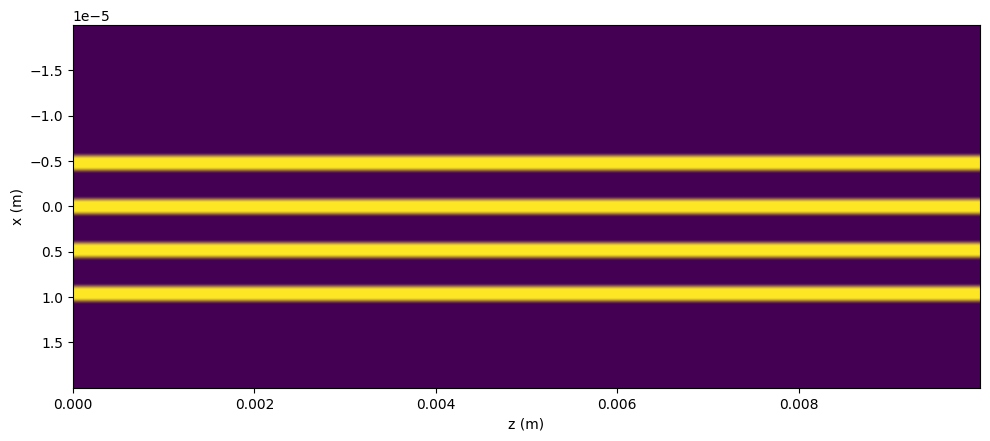

In [7]:
N = 50
refractive_index = torch.zeros(N, 3_000)
wvl = 633e-9

x = torch.linspace(-20e-6, 20e-6, refractive_index.shape[0])
z = torch.linspace(0e-6, 10_000e-6, 3_000)

width = 1e-6
pos1 = 0e-6
pos2 = 5e-6
pos3 = 10e-6
pos4 = -5e-6
refractive_index[:, :] = 0.01 * ((torch.abs(x - pos1) < width) + (torch.abs(x - pos2) < width)\
    + (torch.abs(x - pos3) < width) + (torch.abs(x - pos4) < width)).reshape(x.shape[0], 1)


# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(refractive_index.cpu().numpy(), 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=100,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()

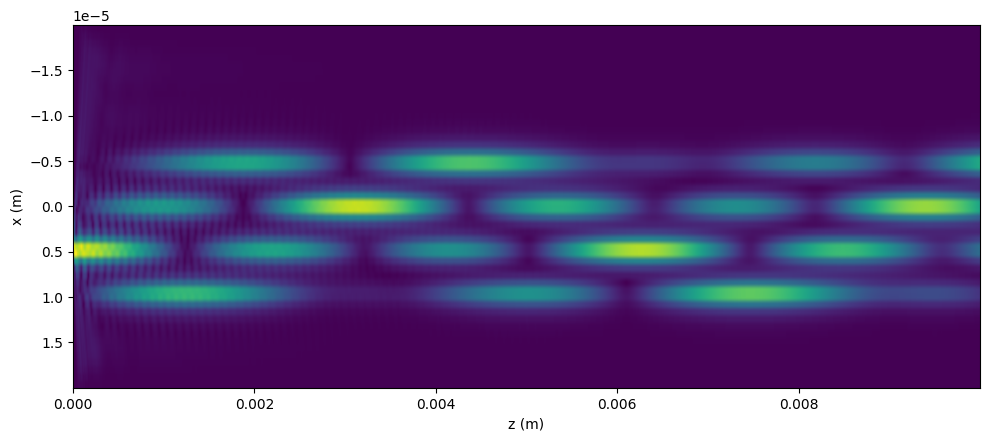

In [8]:
U0 = torch.exp(-(x-x[30])**2 / (2 * 1e-6)**2)
U_prop = fibre_propagation(U0, wvl, x, z, refractive_index)


# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(torch.abs(U_prop)**1, 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=100,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()

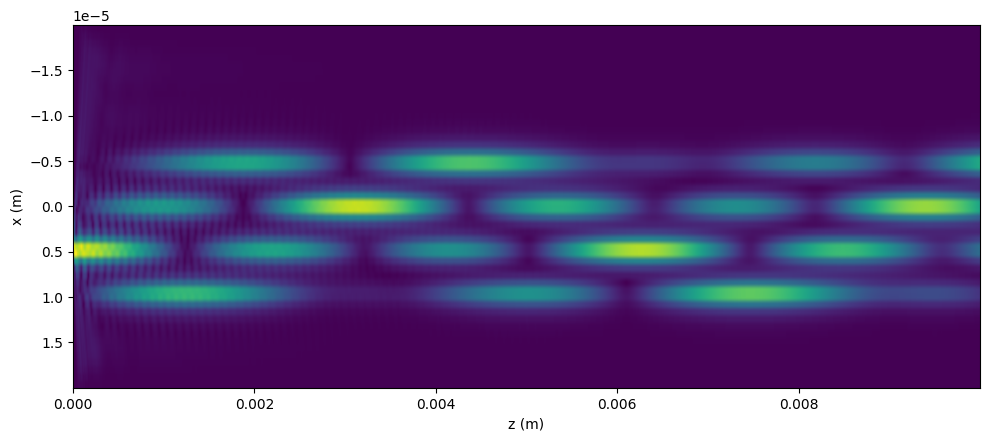

In [9]:
U0 = torch.exp(-(x-x[30])**2 / (2 * 1e-6)**2)
U_prop = fibre_propagation(U0, wvl, x, z, refractive_index)


# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(torch.abs(U_prop)**1, 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=100,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()

In [10]:
def optical_system(U0):
    return fibre_propagation(U0, wvl, x, z, refractive_index)[:, -1]

In [11]:
def build_matrix(K, N=refractive_index.shape[0]):
    # input and outputs
    Xs = torch.zeros(N, K) + 0j
    Ys = torch.zeros(N, K) + 0j

    # probe optical system
    for i in range(50):
        X = torch.exp(-(x-x[i])**2 / (2 * 1e-6)**2) * torch.exp(1j *  2 * torch.pi * torch.rand(N,))
        Xs[:,  i] = X
        Ys[:,  i] = optical_system(X)

    # Calculate pseudoinverse of X
    X_pinv = torch.pinverse(Xs, rcond=1e-3)

    # Solve for M
    M = Ys @ X_pinv
    return M, Ys

In [13]:
M, Ys = build_matrix(50)

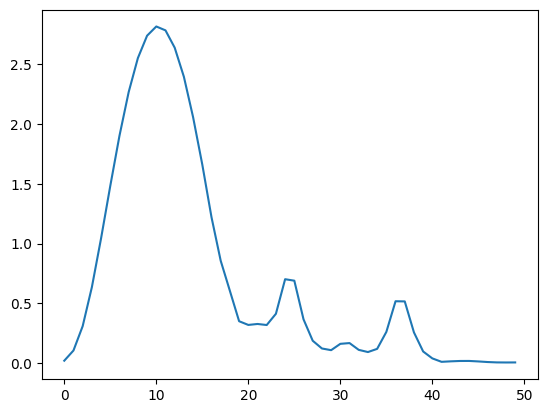

In [342]:
spot = torch.zeros((N,)) + 0j
spot[33:38] = 1

field = (torch.pinverse(M, rcond=1e-3) @ spot)

plt.plot(torch.abs(field))

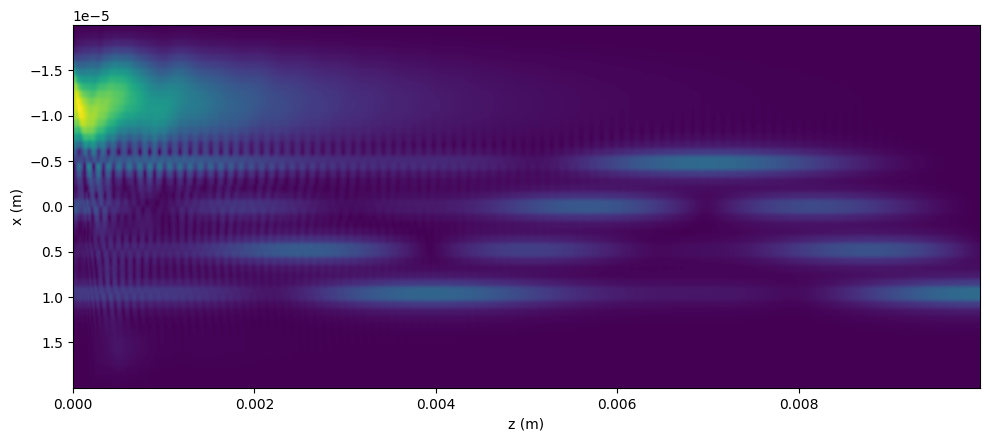

In [343]:
U_prop = fibre_propagation(field, wvl, x, z, refractive_index)


# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(torch.abs(U_prop)**1, 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=100,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()

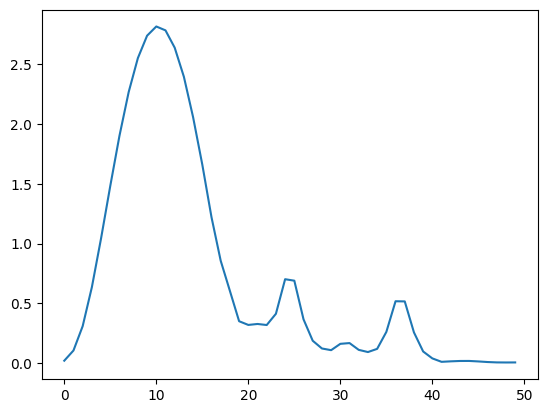

In [344]:
plt.plot(torch.abs(field[:]))

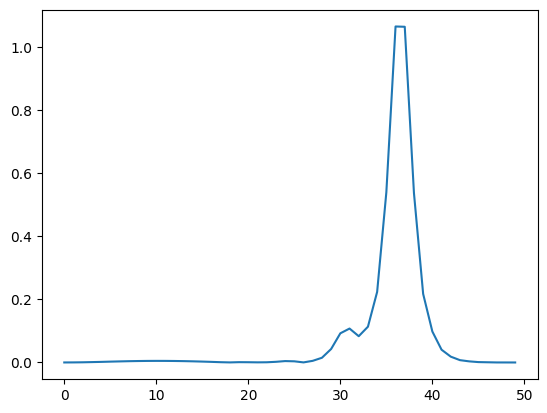

In [345]:
#plt.plot(spot)
#plt.plot(refractive_index[:, -1] * 1000)
plt.plot(torch.abs(U_prop[:, -1]))